In [1]:
### This notebook is for diagnosis of multilayer breaking wave. ###
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
import sys
from scipy.interpolate import griddata
from tqdm import tqdm
sys.path.append('/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/functions/')
from fio import readin
# plt.style.use('/projects/DEIKE/jiarongw/jiarongw-postprocessing/media/matplotlib/stylelib/pof.mplstyle')
plt.style.use('/projects/DEIKE/jiarongw/jiarongw-postprocessing/media/matplotlib/stylelib/thesis.mplstyle')
from fio import readin
import matplotlib as mpl

In [5]:
from func import array_to_mesh, read_t

ModuleNotFoundError: No module named 'func'

/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/functions/fio.py:51: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_table(filename, delimiter = table_delimiter, names = table_headers, error_bad_lines=False)
/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/functions/fio.py:51: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_table(filename, delimiter = table_delimiter, names = table_headers, error_bad_lines=False)
/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/functions/fio.py:51: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_table(filename, delimiter = table_delimiter, names = table_headers, error_bad_lines=False

(0.8, 1.2)

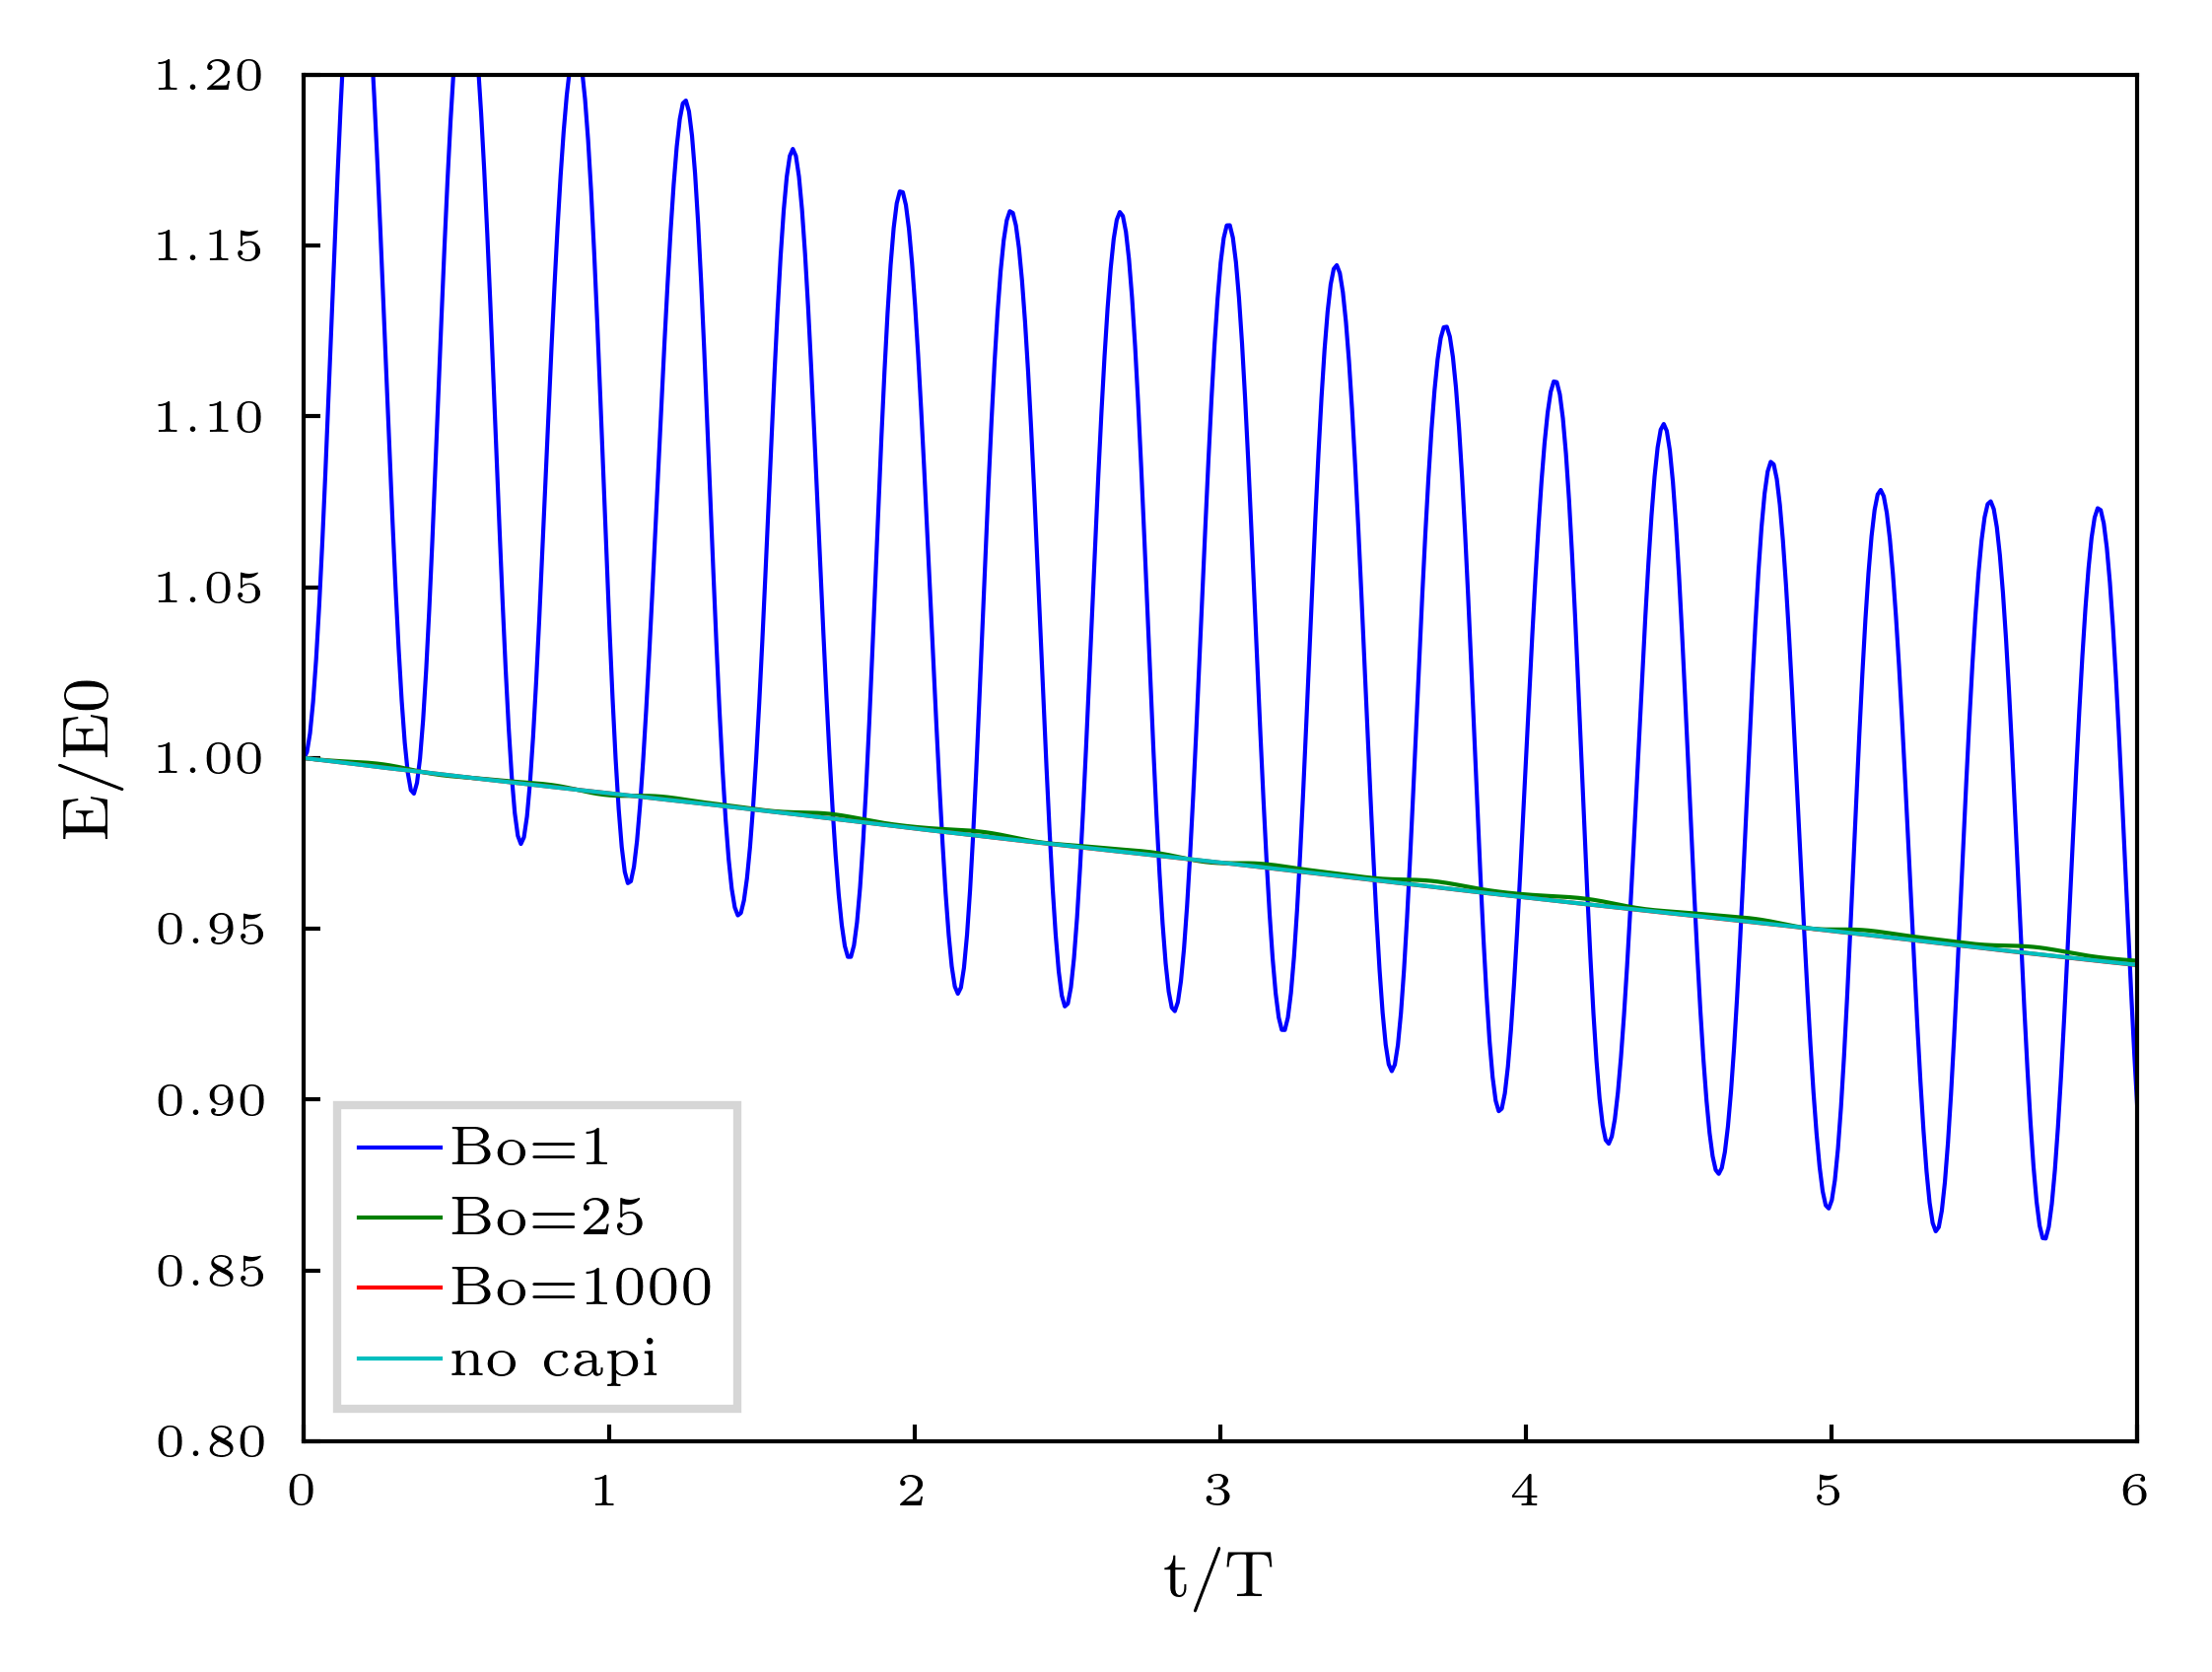

In [92]:
# Stokes energy. Time is scaled by T0

def plot_normalized(ax,energy,tag=' ',line='-',cl='C0'):
    ax.set_prop_cycle(None)
#     ax.plot(energy.t, energy.ke*2/(energy.total[0]), label='2*ke '+tag, linestyle=line)
#     ax.plot(energy.t, energy.gpe*2/(energy.total[0]), '--', label='2*gpe '+tag, linestyle=line)
    ax.plot(energy.t, energy.total/energy.total[0], label=tag, linestyle=line, color=cl)
    ax.set_ylabel("E/E0")

def plot(ax,energy,tag=' ',line='-'):
    ax.set_prop_cycle(None)
#     ax.plot(energy.t, energy.ke, label='ke '+tag, linestyle=line)
#     ax.plot(energy.t, energy.gpe, label='gpe '+tag, linestyle=line)
    ax.plot(energy.t, energy.total/2, label='total/2 '+tag, linestyle=line)
    ax.set_ylabel("E")
    
from scipy.signal import argrelextrema
def fit(ax,energy,localmax=1):
    global T
    t = np.array(energy.t); total = np.array(energy.total)/2
    if localmax:
        localmax_index = argrelextrema(total, np.greater)[0]
        localmax_time = t[localmax_index]
        localmax = total[localmax_index]
        ax.plot(localmax_time,localmax,'.')
        a, b = np.polyfit(localmax_time, np.log(localmax), 1)  
    else:
        a, b = np.polyfit(t, np.log(total), 1)
    ax.plot(t, np.exp(b)*np.exp(a*t), linestyle='-.', label = 'a = %g' %(a/T))
    return (a/T)   

def read(name, skip = None):
    energy,exists = readin(path+name, table_delimiter = ' ', 
                       table_headers = ['t', 'ke', 'gpe'], skipn = skip)
    if exists:
        total = energy.ke + energy.gpe 
    energy.insert(len(energy.columns), "total", total, True)
    return energy
def read_ns(name, skip = 100):
    energy,exists = readin(path+name, table_delimiter = ' ', 
                       table_headers = ['t', 'ke', 'gpe', 'dissipation'], skipn = skip)
    if exists:
        total = energy.ke + energy.gpe 
    energy.insert(len(energy.columns), "total", total, True)
    return energy


fig = plt.figure(figsize=[4,3]); ax = fig.gca()
path = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO1/'
energy1 = read('budget.dat')
plot_normalized(ax,energy1,r'Bo=1',cl='C0')
path = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO25/'
energy1 = read('budget.dat')
plot_normalized(ax,energy1,r'Bo=25',cl='C1')
path = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO1000/'
energy1 = read('budget.dat')
plot_normalized(ax,energy1,r'Bo=1000',cl='C2')
path = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01_nocapi/'
energy1 = read('budget.dat')
plot_normalized(ax,energy1,r'no capi',cl='C3')

# # Comparison with ns
# path = '/home/jiarong/research/projects/multilayer/stokes_ns_movie/'
# path = '/tigress/jiarongw/multilayer/stokes_ns_movie/'
# energy2 = read_ns('budgetWater.dat')
# # energy2 = energy2.mul([1,9.8,9.8,1,9.8])
# plot_normalized(ax,energy2,'NS',cl=plt.cm.get_cmap('tab20c')(4))

plt.legend(loc = 'lower left', handlelength=1.5)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel("t/T"); 
plt.xlim([0,6])
plt.ylim([0.8,1.2])

In [2]:
def read_t(fieldname='eta', t=0, N=256, path=' '):
    filename = path + 'surface/'+ fieldname + '_matrix_%g' %t
    matrix = np.fromfile(filename, dtype=np.float32)
    matrix = matrix.reshape(N+1,N+1); matrix = matrix[1:,1:]
    matrix = np.rot90(matrix)
    return matrix

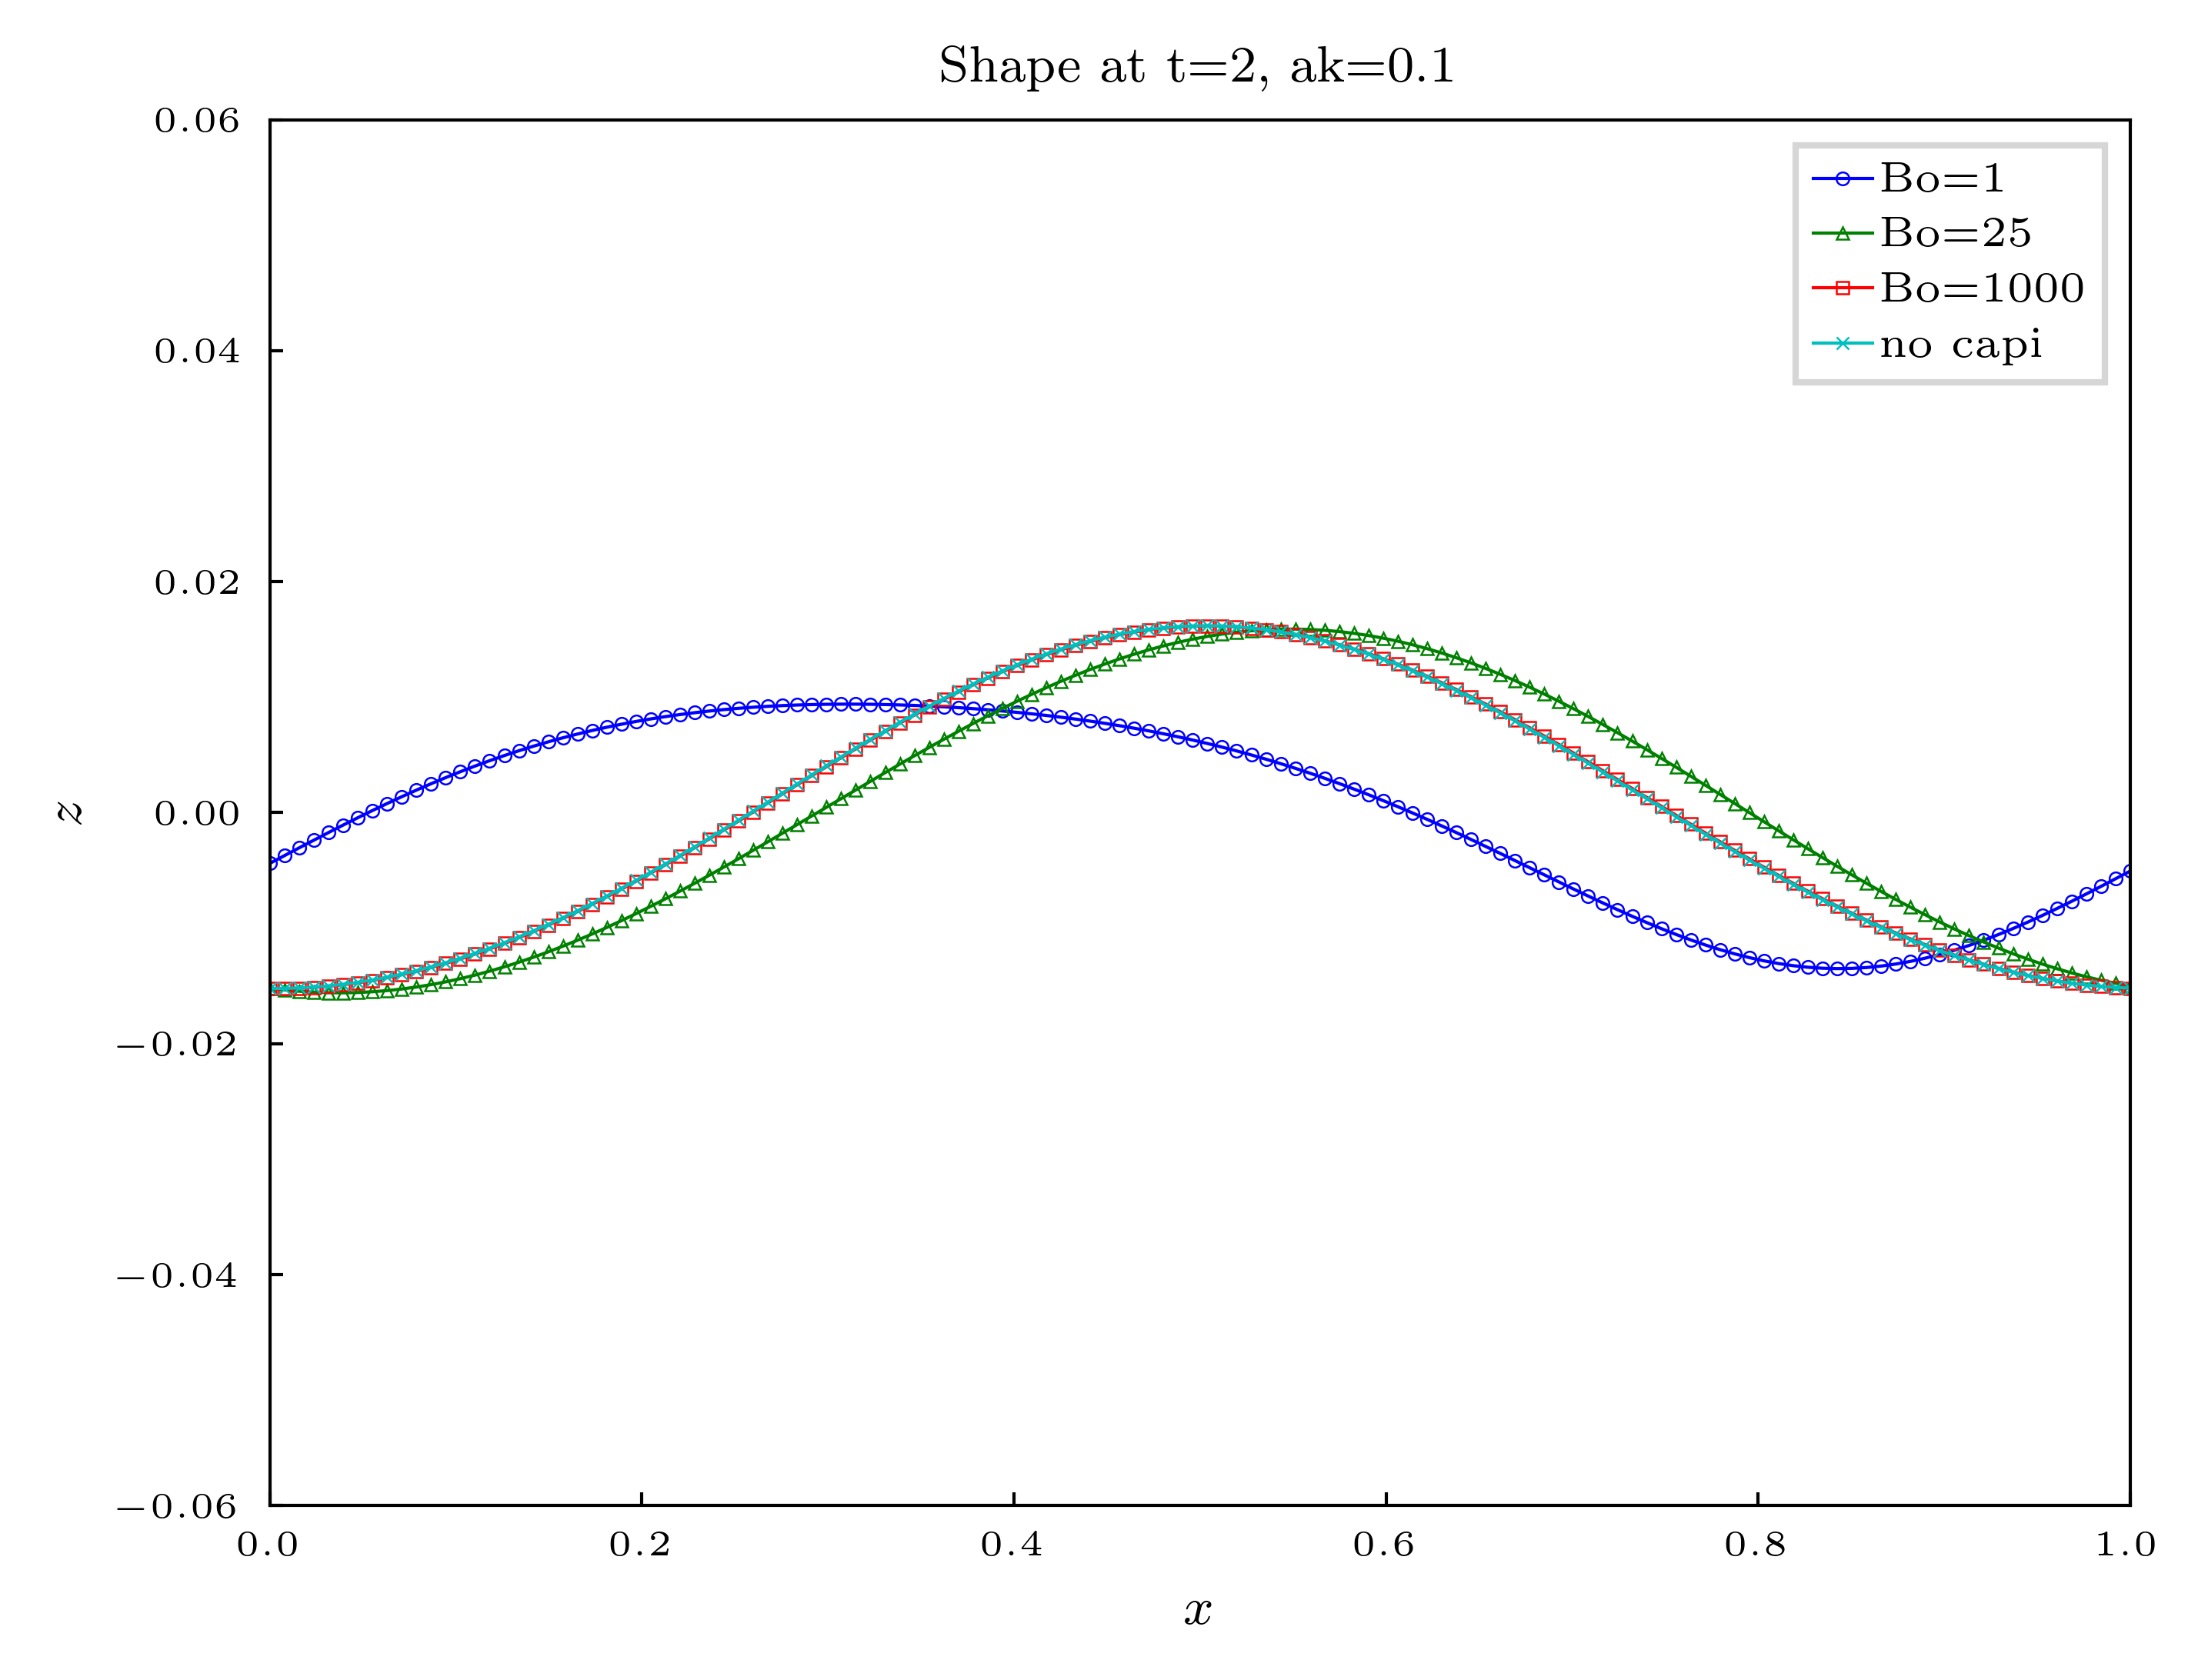

In [91]:
path1 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO1/'
path2 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO25/'
path3 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO1000/'
path4 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01_nocapi/'
paths = [path1,path2,path3,path4]
labels = ['Bo=1','Bo=25','Bo=1000','no capi']
markers = ['o', '^', 's', 'x']

N = 128
x = np.linspace(0,1,128)

for i,path in enumerate(paths):
    t = 2
    eta = read_t('eta', t, N=N, path=path)
    plt.plot(x, eta[0,:], label=labels[i], marker=markers[i])

plt.title('Shape at t=2, ak=0.1')
plt.xlabel('$x$'); plt.ylabel('$z$')
plt.xlim([0,1]); plt.ylim([-0.06,0.06])
plt.legend()

c=0.40


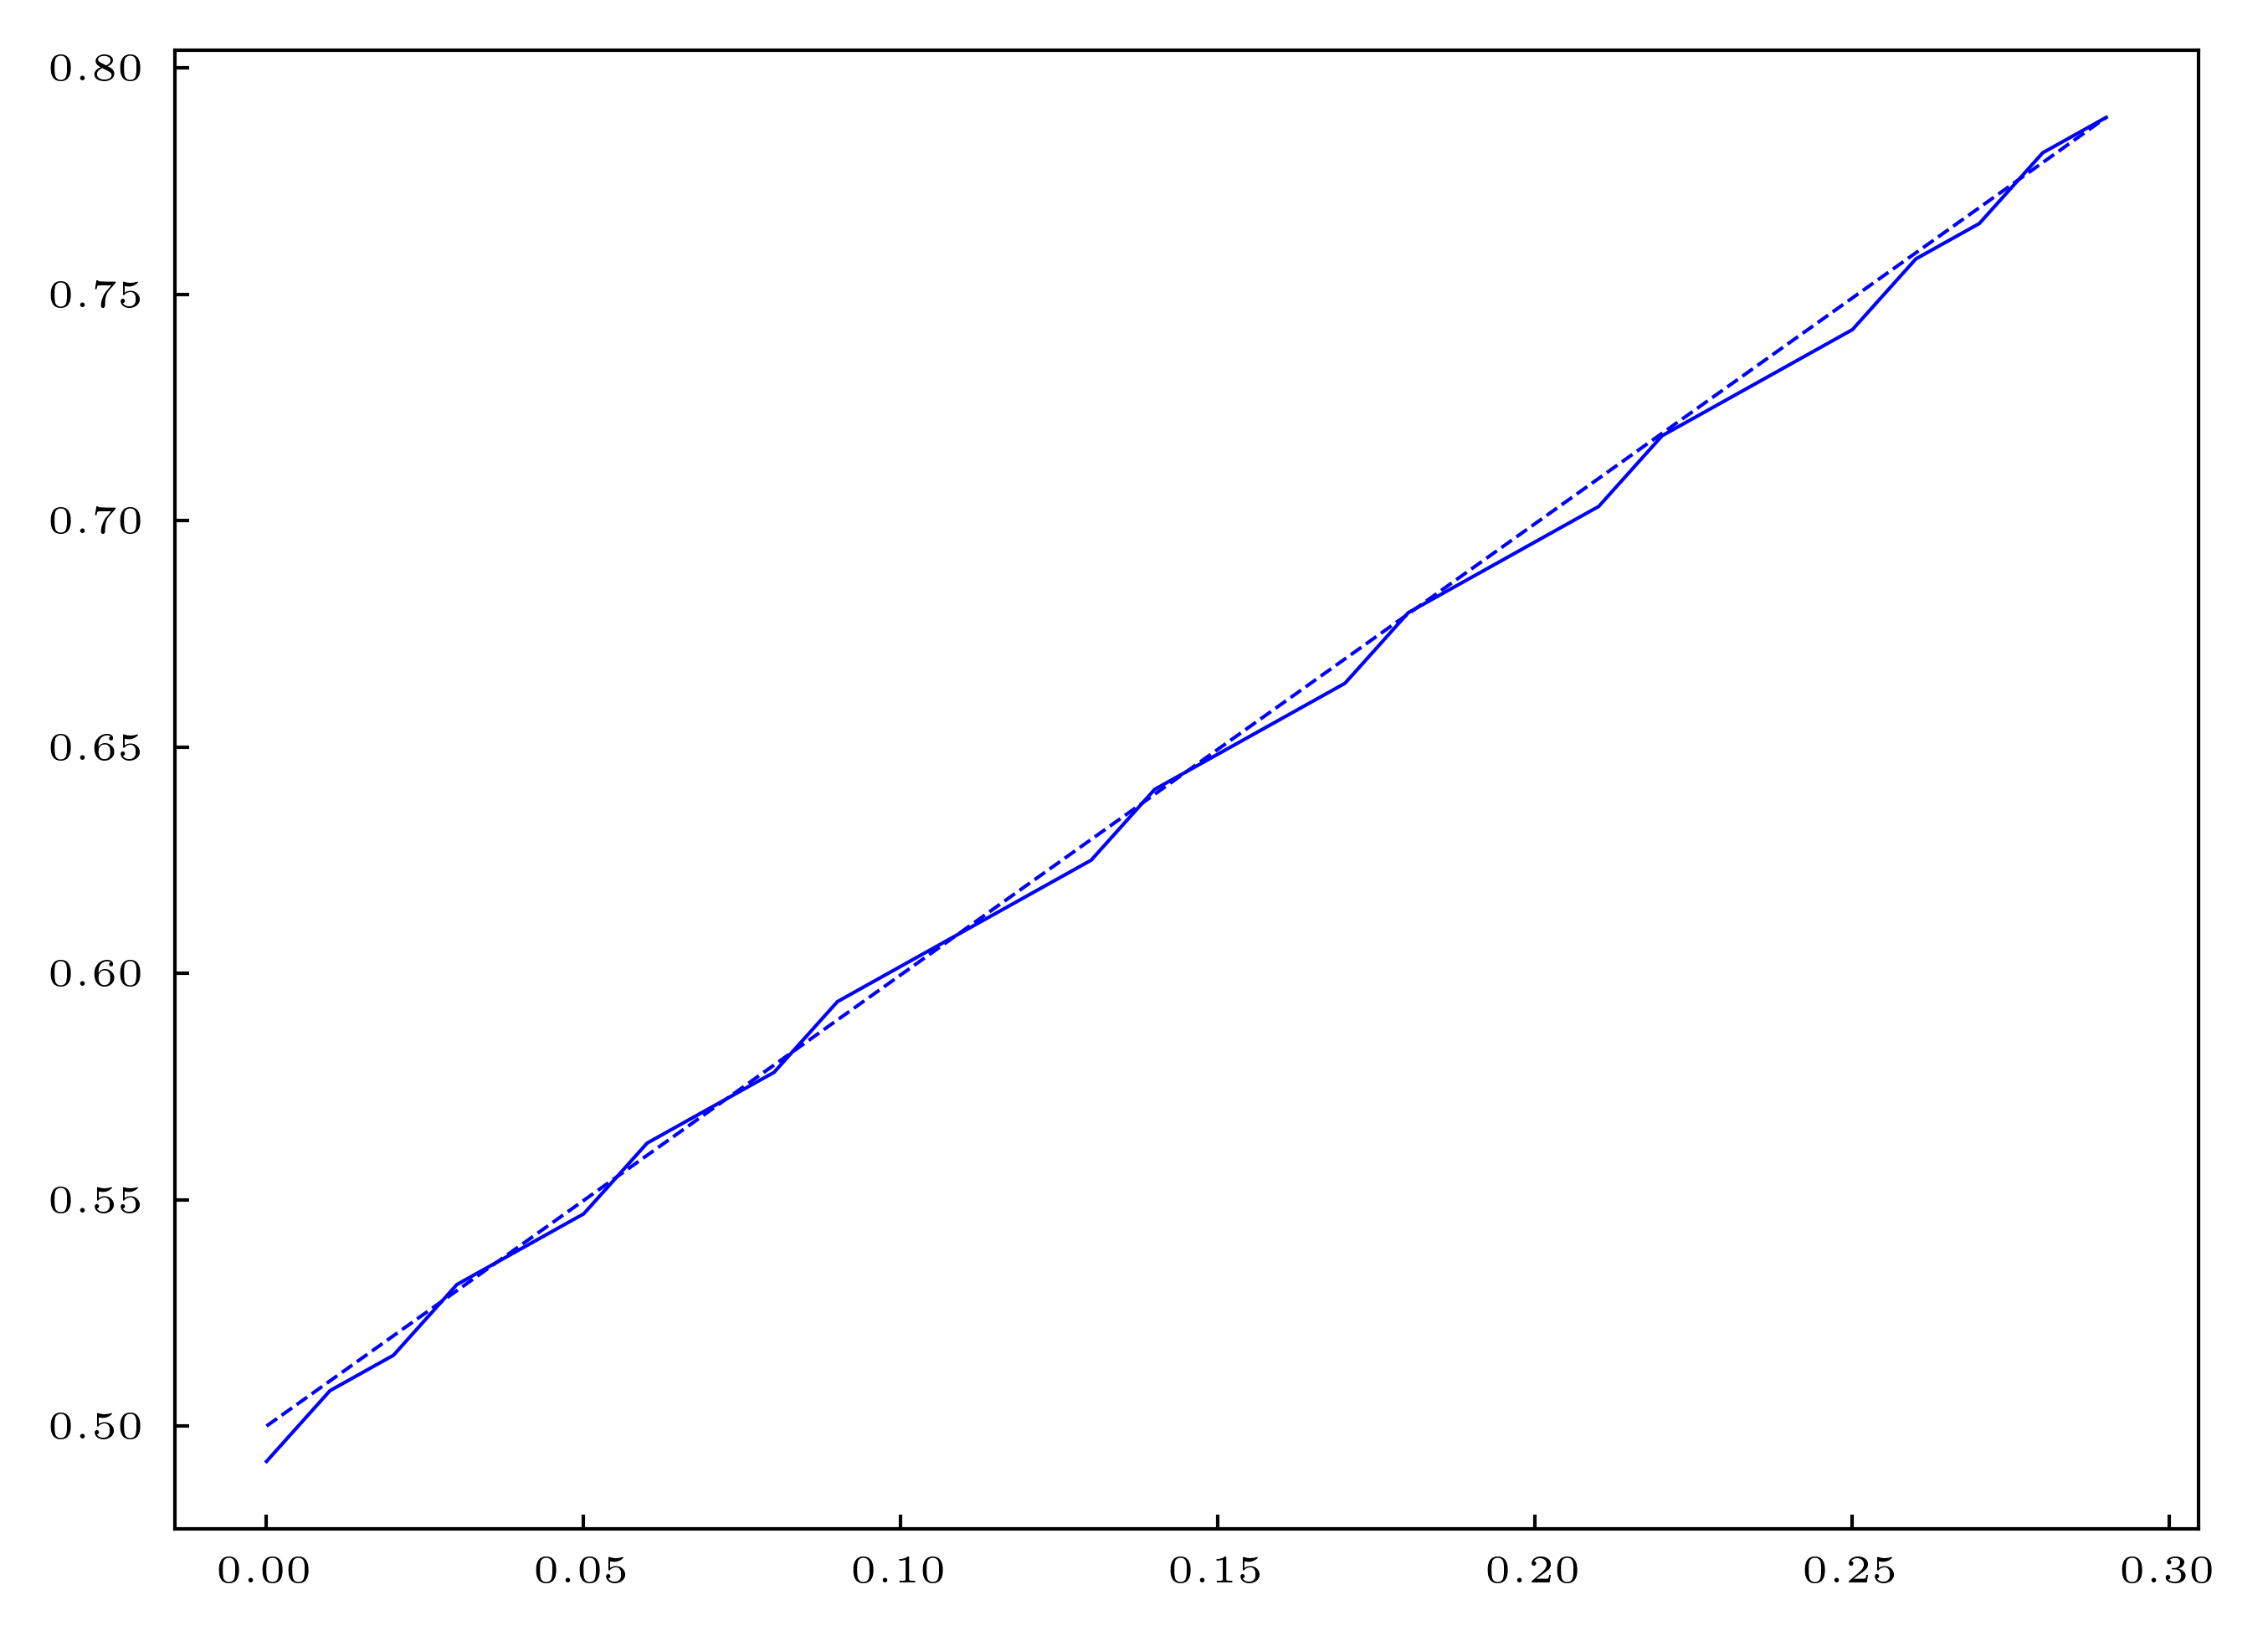

In [34]:
from scipy.signal import hilbert
i = 0
crests = []
ts = np.arange(0,0.3,0.01)
for t in ts:
    eta = read_t('eta', t, N=N, path=path)
    analytic_signal = hilbert(np.average(eta, axis=0))
    phase = np.angle(analytic_signal)
    idx = abs(phase).argmin()
    crests.append(idx)
crests = np.array(crests)
plt.plot(ts, crests/N, label=labels[i])
c = (crests[-1]/N - 0.5)/(ts[-1]*T0)
print('c=%.2f' %c) 
plt.plot(ts, 0.5+c*ts*T0, '--', c=colors[i])

0.6875


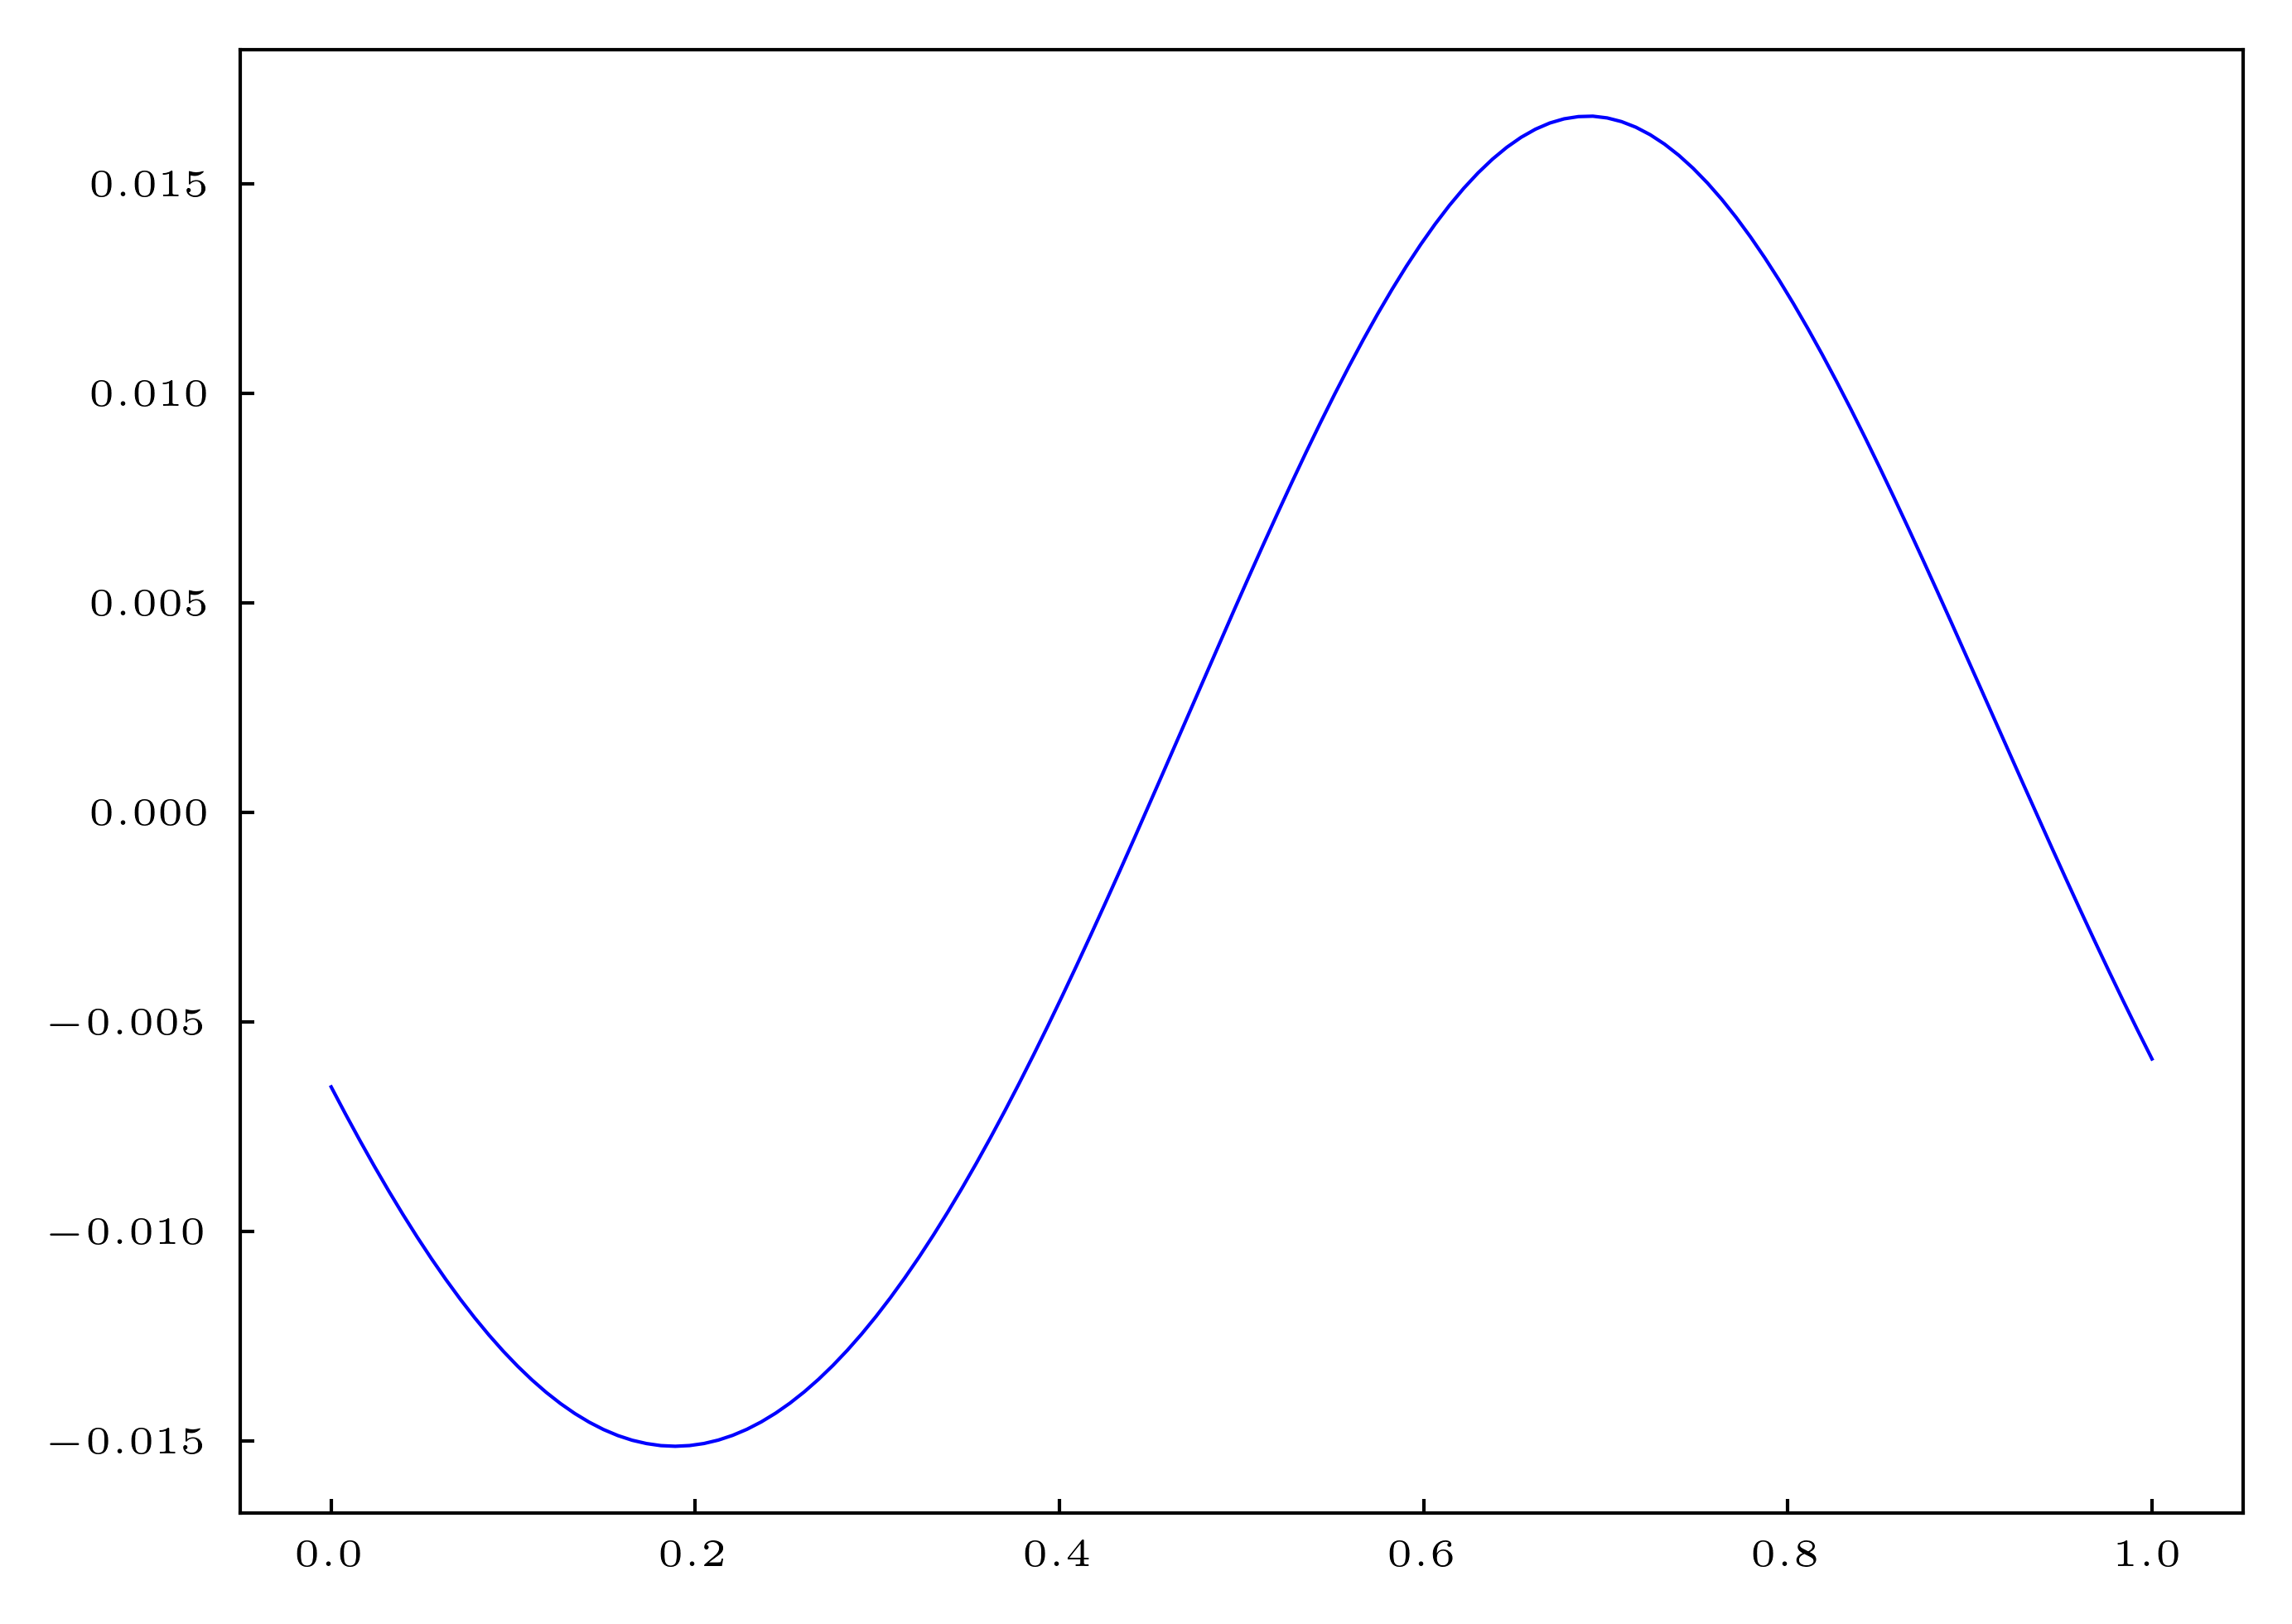

In [33]:
eta_aver = np.average(eta, axis=0)
plt.plot(x, eta_aver)
analytic_signal = hilbert(eta_aver)
phase = np.angle(analytic_signal)
idx = abs(phase).argmin()
print(idx/N)

In [ ]:
path1 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO1/'
path2 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO1_N/'
path3 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO1000/'
path4 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01_nocapi/'
paths = [path1,path2,path3,path4]
labels = ['Bo=1','Bo=25','Bo=1000','no capi']
markers = ['o', '^', 's', 'x']
colors = ['C0', 'C1', 'C2', 'C3']
T0 = 2*np.pi/(1*2*np.pi)**0.5
ts = np.arange(0,2,0.01)

N = 128
x = np.linspace(0,1,128)

fig = plt.figure(figsize=[4,2])
crests_ensem = []
for i,path in enumerate(paths):
    crests = []
    for t in ts:
        eta = read_t('eta', t, N=N, path=path)
        # crest = np.argmax(np.average(eta,axis=0))
        # crests.append(crest)
        eta = read_t('eta', t, N=N, path=path)
        analytic_signal = hilbert(np.average(eta, axis=0))
        phase = np.angle(analytic_signal)
        idx = abs(phase).argmin()
        crests.append(idx)
    crests = np.array(crests)
    plt.plot(ts, crests/N, label=labels[i])
    crests_ensem.append(crests)

plt.legend()
plt.xlabel('$t$'); plt.ylabel('$x_{crest}$')

Text(0, 0.5, '$x_{crest}$')

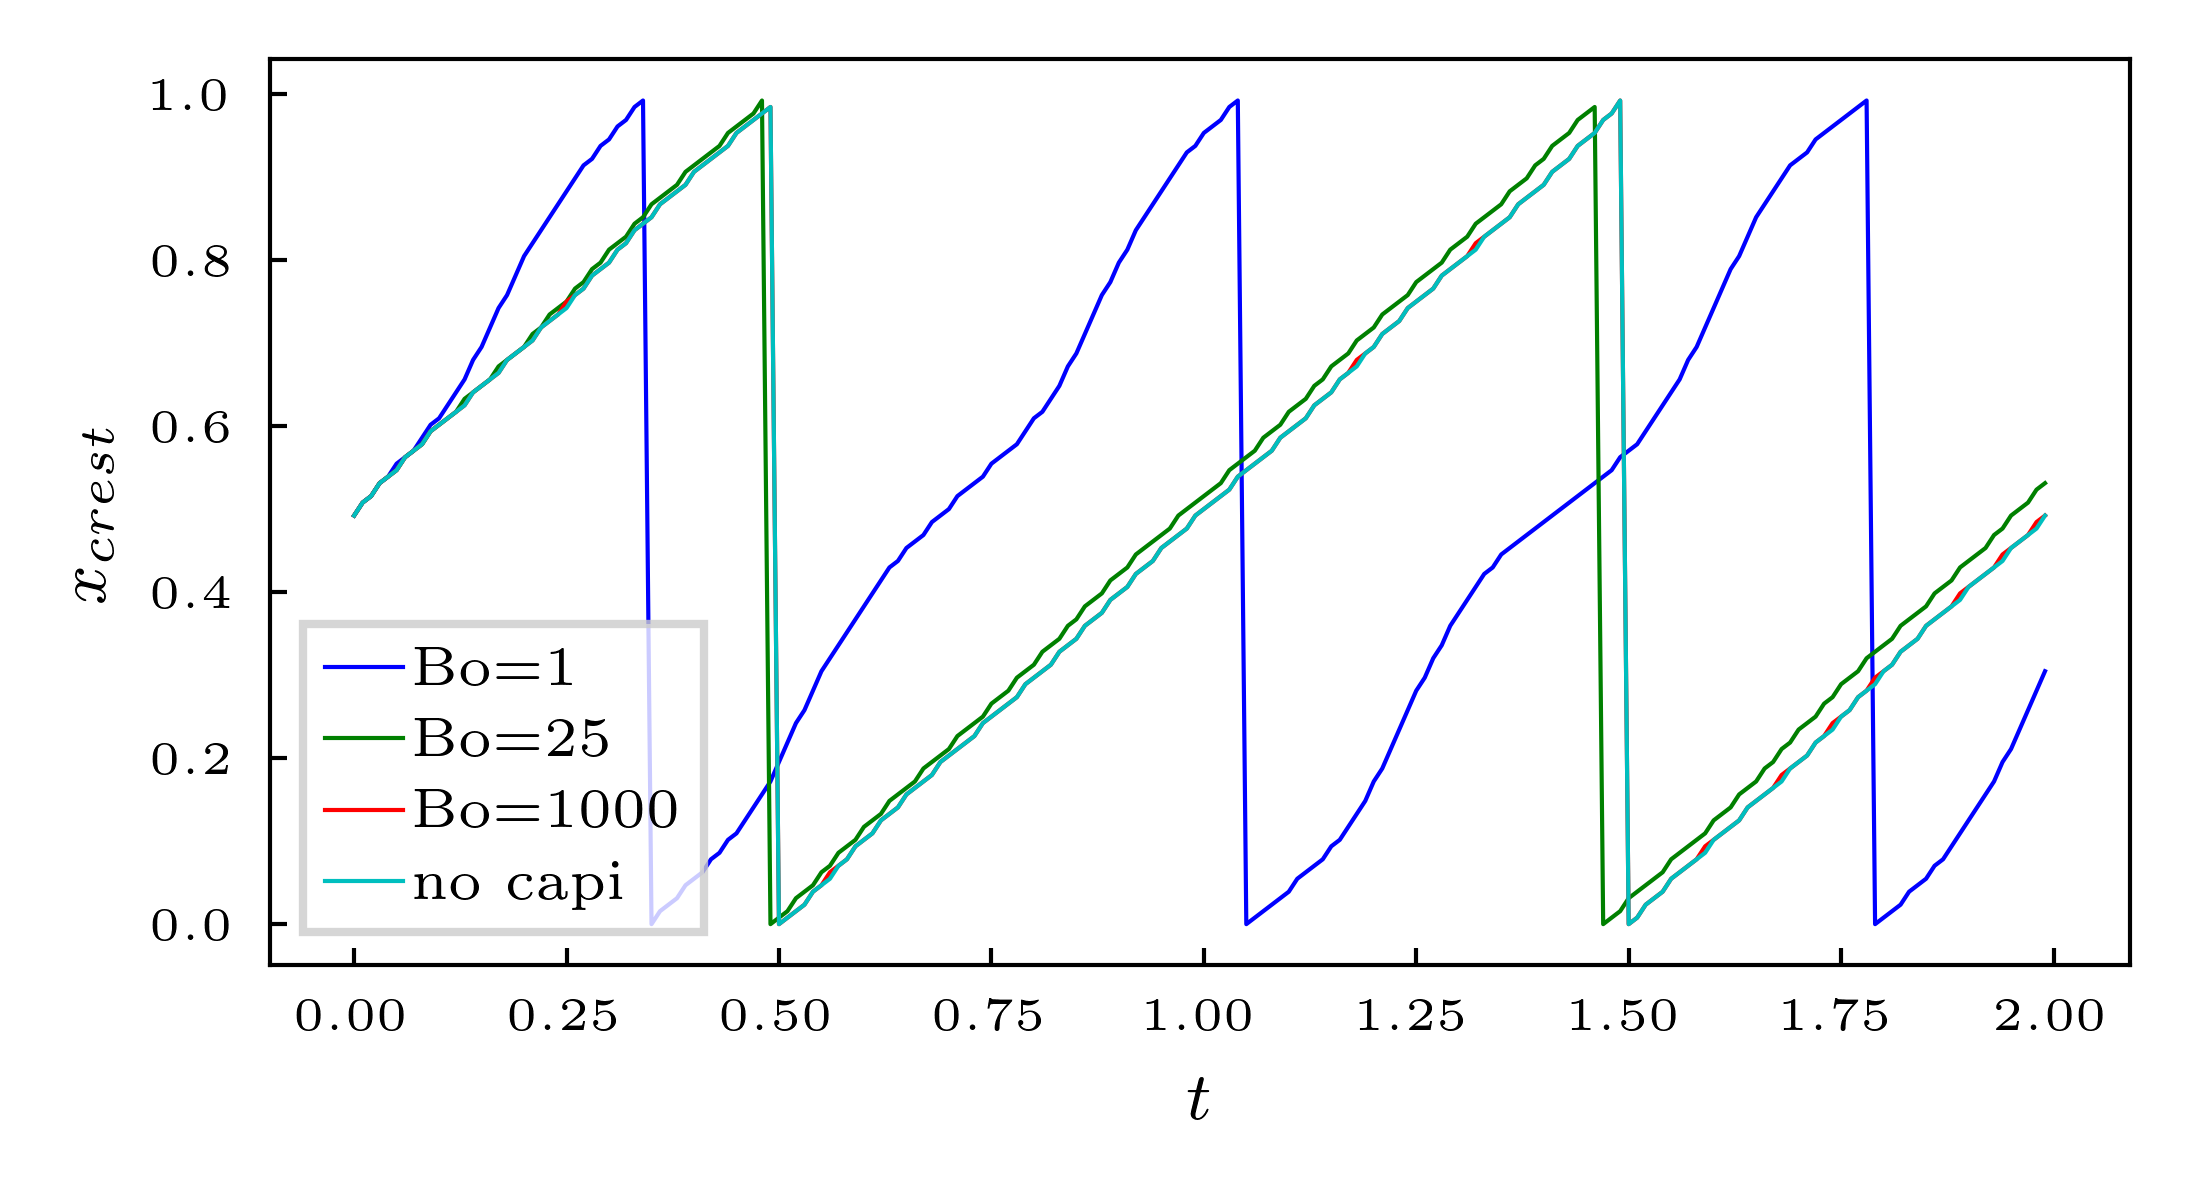

In [71]:
path1 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO1/'
path2 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO25/'
path3 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO1000/'
path4 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01_nocapi/'
paths = [path1,path2,path3,path4]
labels = ['Bo=1','Bo=25','Bo=1000','no capi']
markers = ['o', '^', 's', 'x']
colors = ['C0', 'C1', 'C2', 'C3']
T0 = 2*np.pi/(1*2*np.pi)**0.5
ts = np.arange(0,2,0.01)

N = 128
x = np.linspace(0,1,128)

fig = plt.figure(figsize=[4,2])
crests_ensem = []
for i,path in enumerate(paths):
    crests = []
    for t in ts:
        eta = read_t('eta', t, N=N, path=path)
        # crest = np.argmax(np.average(eta,axis=0))
        # crests.append(crest)
        eta = read_t('eta', t, N=N, path=path)
        analytic_signal = hilbert(np.average(eta, axis=0))
        phase = np.angle(analytic_signal)
        idx = abs(phase).argmin()
        crests.append(idx)
    crests = np.array(crests)
    plt.plot(ts, crests/N, label=labels[i])
    crests_ensem.append(crests)

plt.legend()
plt.xlabel('$t$'); plt.ylabel('$x_{crest}$')

In [60]:
print(np.argmin(crests_ensem[0]))
print(np.argmax(crests_ensem[0][35:]))
print(np.argmax(crests_ensem[0][35+69+1:]))

35
69
73


In [55]:
c_BO1 = (crests_ensem[0][69+35] - crests_ensem[0][35])/N/((ts[69+35]-ts[35])*T0)
print(c_BO1)

0.5736602084576761


In [69]:
print(np.argmin(crests_ensem[1]))
print(np.argmax(crests_ensem[1][49:]))

49
97


In [74]:
c_BO25 = (crests_ensem[1][49+97] - crests_ensem[1][49])/N/((ts[49+97]-ts[49])*T0)
print(c_BO25)

0.4048544404847013


In [ ]:
print(np.argmin(crests_ensem[0]))
print(np.argmax(crests_ensem[0][35:]))

Text(0.05, 0.9, 'Bo=1000, $c_\\mathrm{num}=0.398$, $c_\\mathrm{theo}=0.399$')

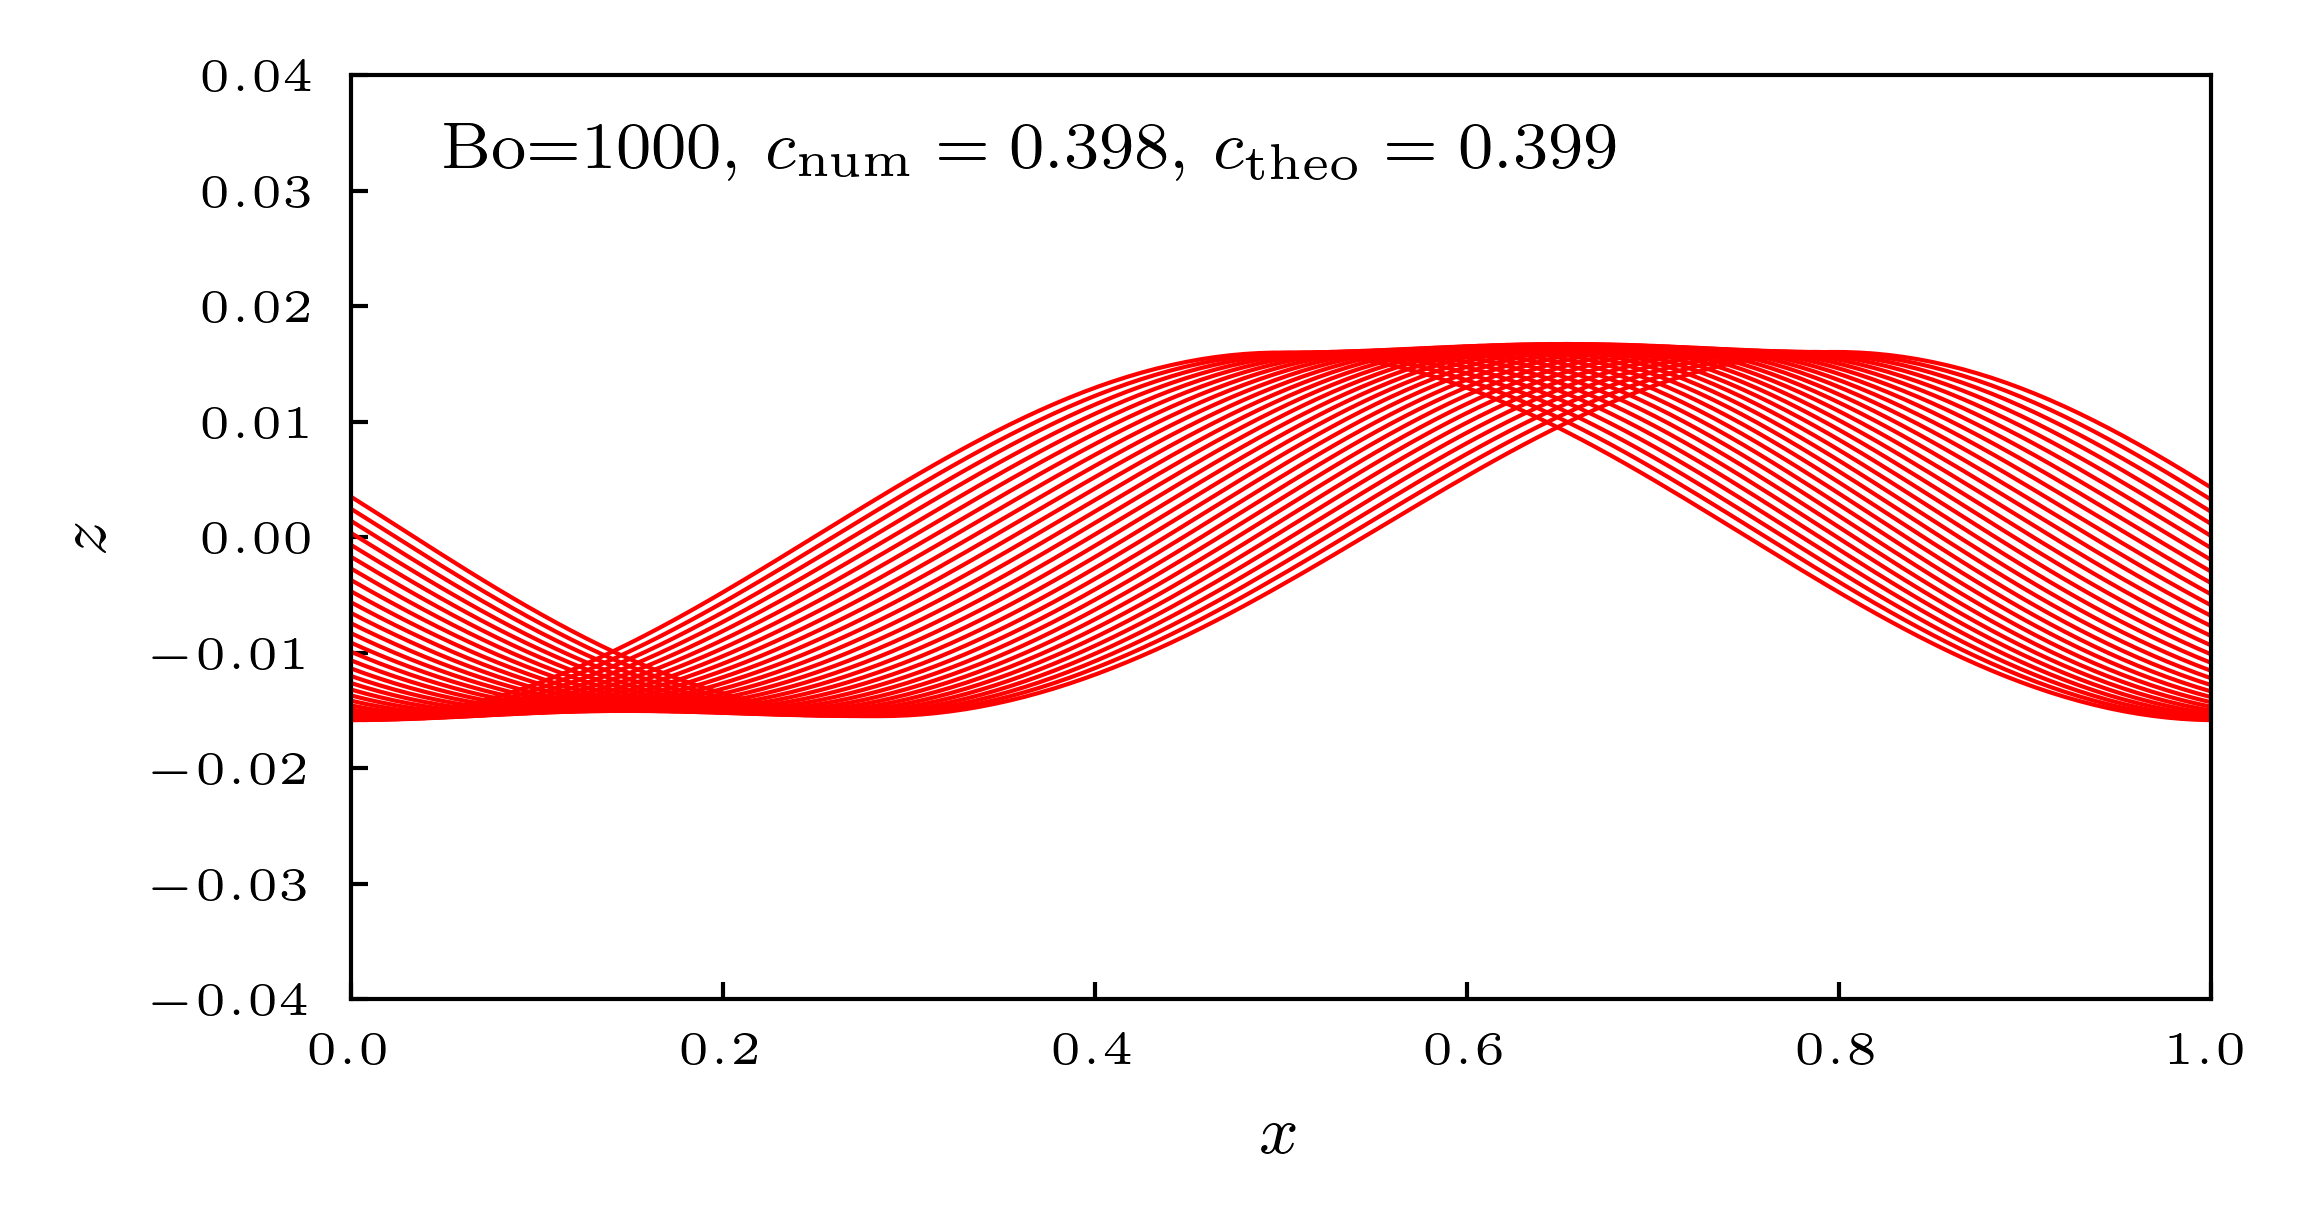

In [89]:
path1 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO1/'
path2 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO25/'
path3 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO1000/'
path4 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01_nocapi/'
paths = [path1,path2,path3,path4]
Bos = [1, 25, 1000, 100000]
labels = ['Bo=1','Bo=25','Bo=1000','no capi']
markers = ['o', '^', 's', 'x']
colors = ['C0', 'C1', 'C2', 'C3']
T0 = 2*np.pi/(1*2*np.pi)**0.5 # time output was normalized
ts = np.arange(0,0.3,0.01)

N = 128
x = np.linspace(0,1,128)

fig = plt.figure(figsize=[4,2]); ax = plt.gca()
i = 2
crests = []
for t in ts:
    eta = read_t('eta', t, N=N, path=paths[i])
    crest = np.argmax(eta[int(N/2),:])
    crests.append(crest)
    c = (crests[-1]/N - 0.5)/(ts[-1]*T0)
    plt.plot(x,eta[int(N/2),:], c=colors[i])

plt.xlabel('$x$'); plt.ylabel('$z$')
plt.xlim([0,1]); plt.ylim([-0.04,0.04])
c_theo = (1*(1+1/Bos[i])/(2*np.pi))**0.5
ax.text(0.05, 0.9, 'Bo=%g, $c_\mathrm{num}=%.3f$, $c_\mathrm{theo}=%.3f$' %(Bos[i], c, c_theo), transform=ax.transAxes)

Text(0.05, 0.9, 'Bo=25, $c_\\mathrm{num}=0.405$, $c_\\mathrm{theo}=0.407$')

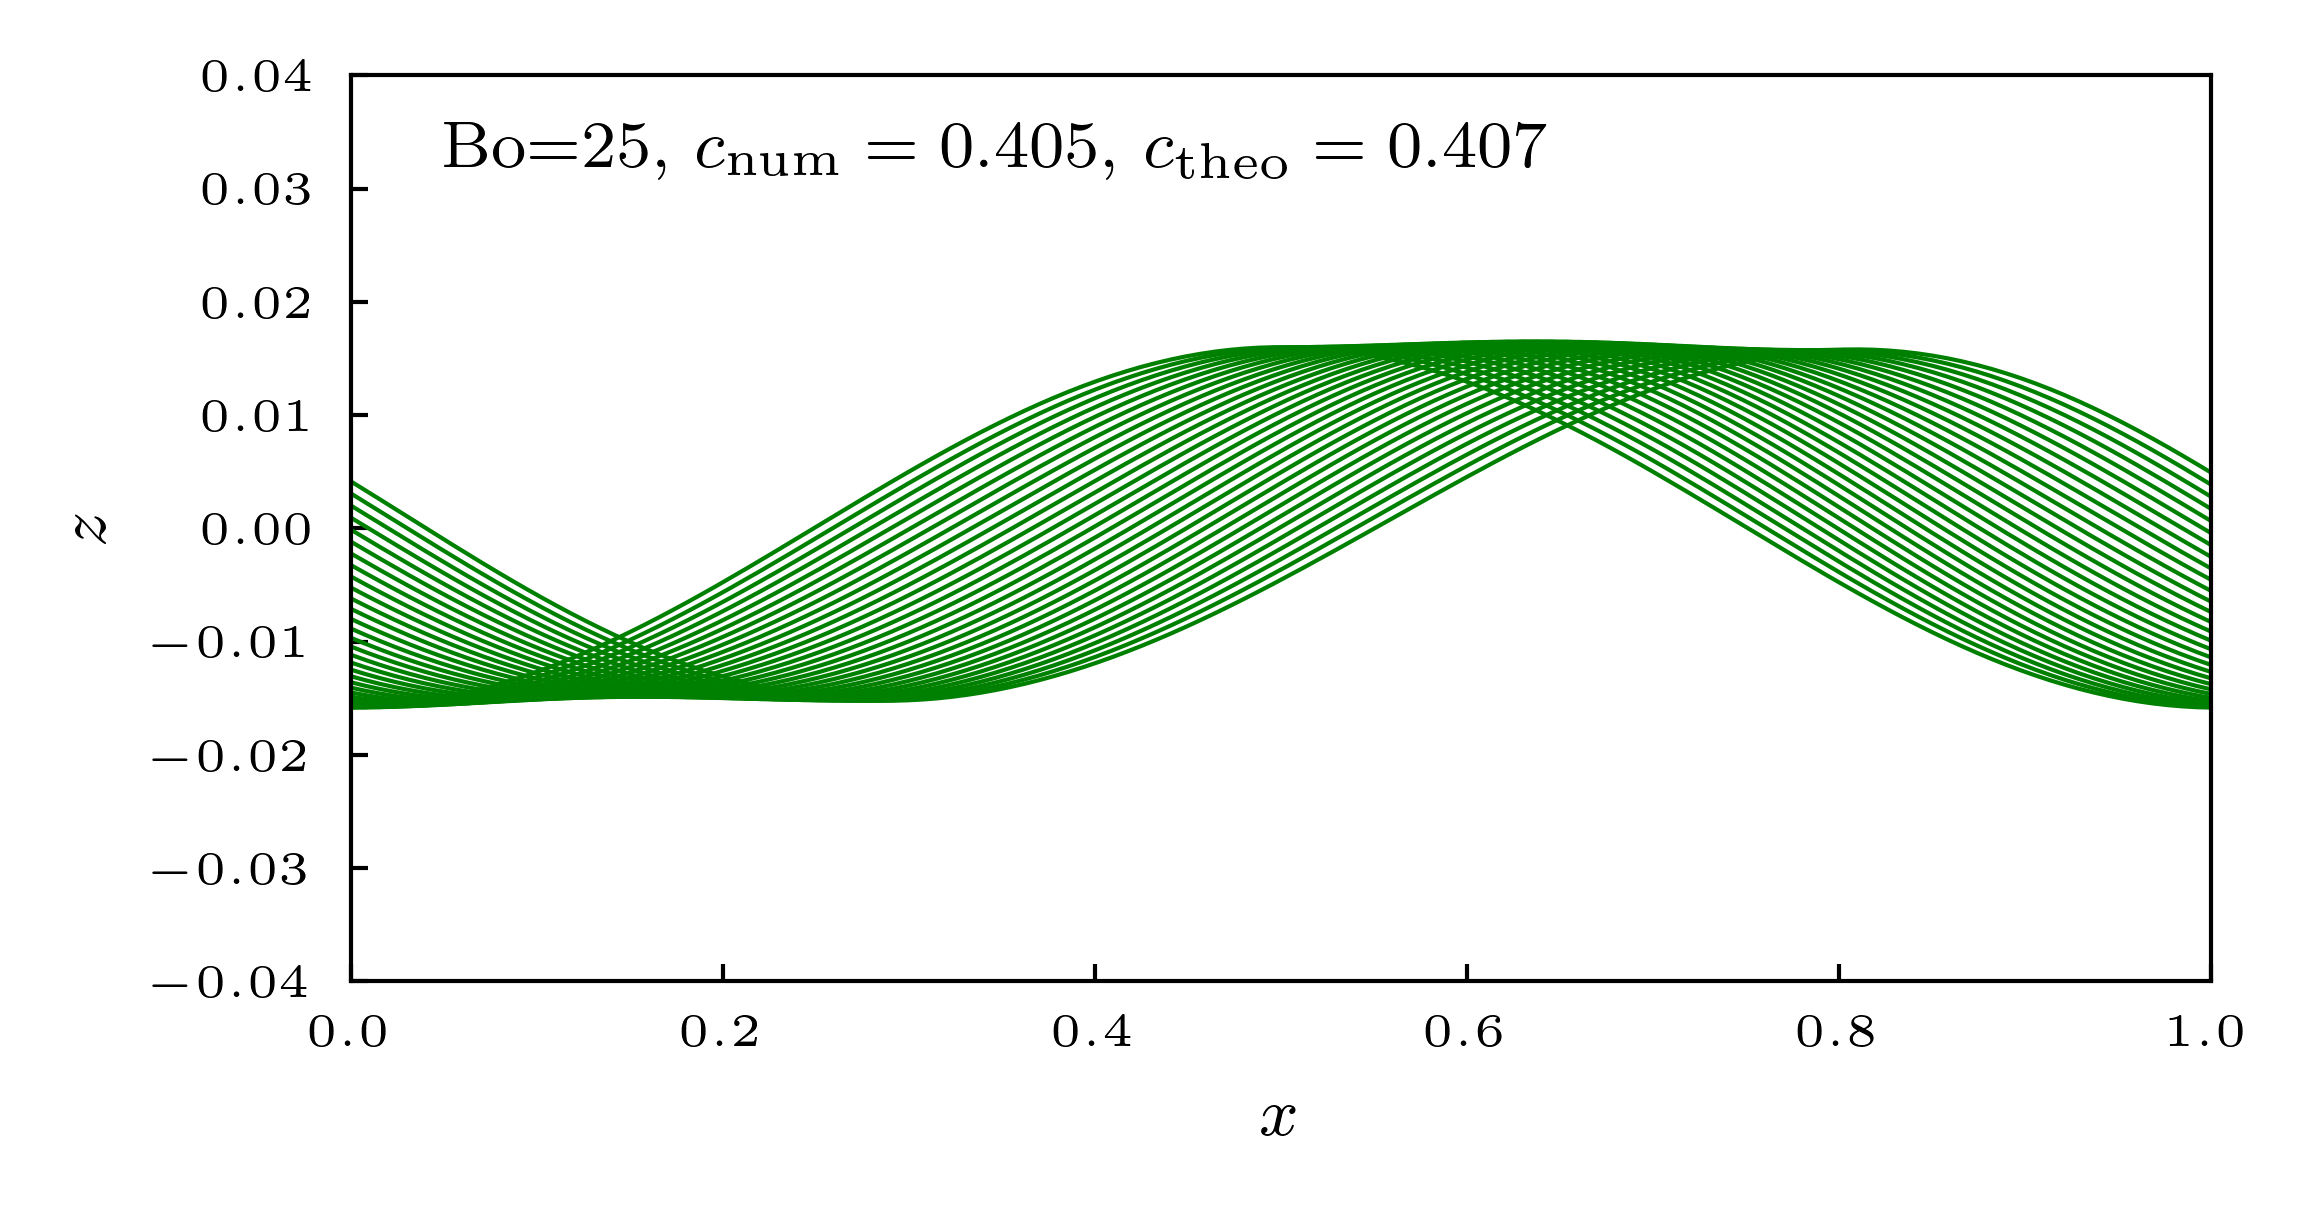

In [77]:
path1 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO1/'
path2 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO25/'
path3 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO1000/'
path4 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01_nocapi/'
paths = [path1,path2,path3,path4]
Bos = [1, 25, 1000, 100000]
labels = ['Bo=1','Bo=25','Bo=1000','no capi']
markers = ['o', '^', 's', 'x']
colors = ['C0', 'C1', 'C2', 'C3']
T0 = 2*np.pi/(1*2*np.pi)**0.5 # time output was normalized
ts = np.arange(0,0.3,0.01)

N = 128
x = np.linspace(0,1,128)

fig = plt.figure(figsize=[4,2]); ax = plt.gca()
i = 1
crests = []
for t in ts:
    eta = read_t('eta', t, N=N, path=paths[i])
    crest = np.argmax(eta[int(N/2),:])
    crests.append(crest)
    c = (crests[-1]/N - 0.5)/(ts[-1]*T0)
    plt.plot(x,eta[int(N/2),:], c=colors[i])

plt.xlabel('$x$'); plt.ylabel('$z$')
plt.xlim([0,1]); plt.ylim([-0.04,0.04])
c_theo = (1*(1+1/Bos[i])/(2*np.pi))**0.5
ax.text(0.05, 0.9, 'Bo=%g, $c_\mathrm{num}=%.3f$, $c_\mathrm{theo}=%.3f$' %(Bos[i], c_BO25, c_theo), transform=ax.transAxes)

Text(0.05, 0.9, 'Bo=1, $c_\\mathrm{num}=0.574$, $c_\\mathrm{theo}=0.564$')

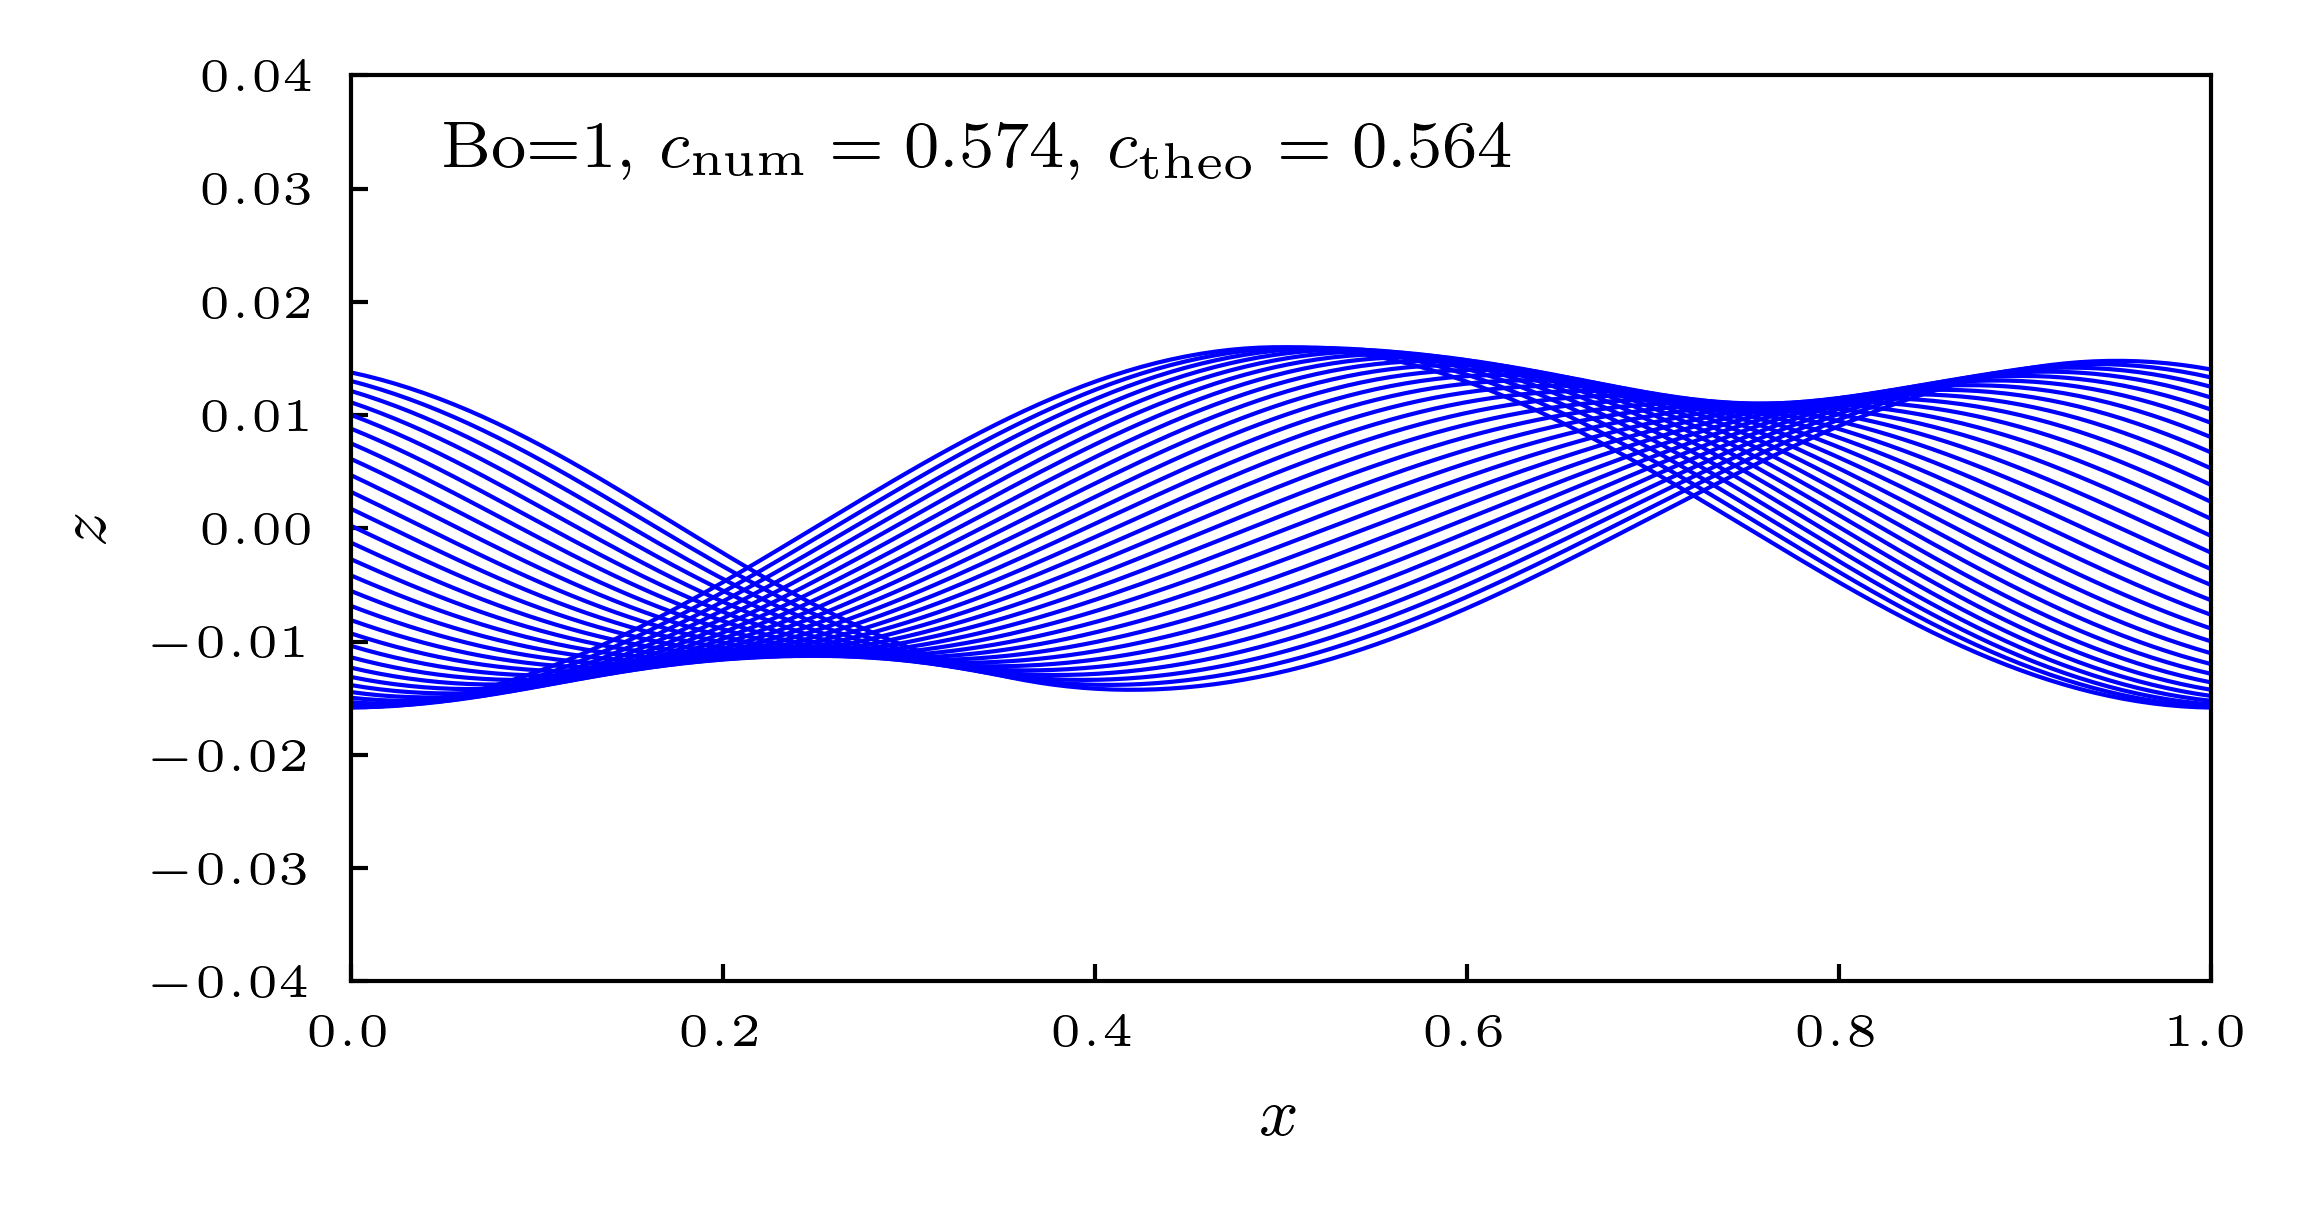

In [57]:
path1 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO1/'
path2 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO1N512L30/'
path3 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01BO1N512L15/'
path4 = '/projects/DEIKE/jiarongw/multilayer/tests/stokes_ml_capi_test/ak01_nocapi/'
paths = [path1,path2,path3,path4]
Bos = [1, 1, 1, 100000]
labels = ['Bo=1','Bo=25','Bo=1000','no capi']
markers = ['o', '^', 's', 'x']
colors = ['C0', 'C1', 'C2', 'C3']
T0 = 2*np.pi/(1*2*np.pi)**0.5 # time output was normalized
ts = np.arange(0,0.3,0.01)

N = 128
x = np.linspace(0,1,N)

fig = plt.figure(figsize=[4,2]); ax = plt.gca()
i = 0
crests = []
for t in ts:
    eta = read_t('eta', t, N=N, path=paths[i])
    crest = np.argmax(eta[int(N/2),:])
    crests.append(crest)
    c = (crests[-1]/N - 0.5)/(ts[-1]*T0)
    plt.plot(x,eta[int(N/2),:], c=colors[i])

plt.xlabel('$x$'); plt.ylabel('$z$')
plt.xlim([0,1]); plt.ylim([-0.04,0.04])
c_theo = (1*(1+1/Bos[i])/(2*np.pi))**0.5
ax.text(0.05, 0.9, 'Bo=%g, $c_\mathrm{num}=%.3f$, $c_\mathrm{theo}=%.3f$' %(Bos[i], c_BO1, c_theo), transform=ax.transAxes)